In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
if torch.cuda.is_available():
    print("Using cuda")
    torch.set_default_device('cuda:0')

Using cuda


In [3]:
dataset_folder = os.path.join(".", "dataset")
print(os.listdir(dataset_folder))

['1652875851.3497071', '1652875851.3497071.csv', '1652875901.3107166', '1652875901.3107166.csv', '1652876013.741493', '1652876013.741493.csv', '1652876206.2541456', '1652876206.2541456.csv', '1652876485.8123376', '1652876485.8123376.csv', '1652959186.4507334', '1652959186.4507334.csv', '1652959347.972946', '1652959347.972946.csv', '1653042695.4914637', '1653042695.4914637.csv', '1653042775.5213027', '1653042775.5213027.csv', '1653043202.5073502', '1653043202.5073502.csv', '1653043345.3415065', '1653043345.3415065.csv', '1653043428.8546412', '1653043428.8546412.csv', '1653043549.5187616', '1653043549.5187616.csv']


In [4]:
X = []
y = []

for file in os.listdir(dataset_folder):
    if not file.endswith(".csv"):
        continue

    dataset_name = file[:-4]

    data = pd.read_csv(os.path.join(dataset_folder, str(file)), header=None)

    for _, row in data.iterrows():
        img_id, forward, left = row
        img_path = os.path.join(dataset_folder, dataset_name, f"{int(img_id):04d}.jpg")

        X.append(img_path)
        y.append([forward, left])

X = np.array(X)
y = np.array(y, dtype=np.float32)

X.shape, y.shape

((7584,), (7584, 2))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)

In [6]:
class JetBotImageDataset(Dataset):
    def __init__(self, image_paths, image_ys, transform=None):
        self.image_paths = image_paths
        self.image_ys = image_ys
        self.transform = transform

        assert len(image_paths) == len(image_ys)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = self.image_ys[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
transform = v2.Compose([
    v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.75, 1.25)),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
train_dataset = JetBotImageDataset(X_train, y_train, transform)
test_dataset = JetBotImageDataset(X_test, y_test, transform)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [10]:
train_features, train_labels = next(iter(test_dataloader))

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

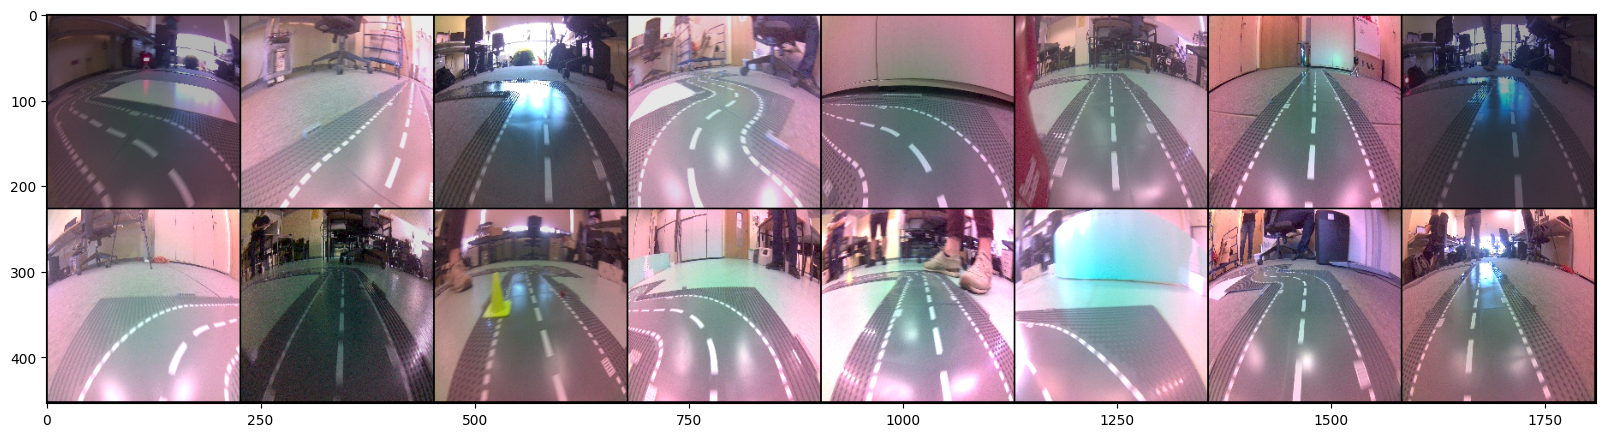

In [12]:
imshow(torchvision.utils.make_grid(train_features))

In [13]:
class SteeringCNN(nn.Module):
    def __init__(self):
        super(SteeringCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.forward_layers = nn.Sequential(
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        self.left_layers = nn.Sequential(
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        forward = self.forward_layers(x)
        left = self.left_layers(x)
        return torch.cat((forward, left), dim=1)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [15]:
net = SteeringCNN()
net.to(device)

SteeringCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (forward_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (left_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [19]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [21]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            last_loss = running_loss / 50
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
    return last_loss

In [23]:
for epoch in range(3):
    print('EPOCH {}:'.format(epoch + 1))
    
    net.train(True)
    avg_loss = train_one_epoch(epoch)
    
    running_vloss = 0.0
    
    net.eval()
    
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
            

EPOCH 1:
  batch 50 loss: 0.23114356979727746
  batch 100 loss: 0.21625851638615132
  batch 150 loss: 0.22118156522512436
  batch 200 loss: 0.23083008229732513
  batch 250 loss: 0.2361881074309349
  batch 300 loss: 0.22303105145692825
  batch 350 loss: 0.24590928584337235
LOSS train 0.24590928584337235 valid 0.2248505800962448
EPOCH 2:
  batch 50 loss: 0.23109391778707505
  batch 100 loss: 0.21549239173531531
  batch 150 loss: 0.22127155035734178
  batch 200 loss: 0.22985436722636224
  batch 250 loss: 0.23665082424879075
  batch 300 loss: 0.22247366577386857
  batch 350 loss: 0.2453130492568016
LOSS train 0.2453130492568016 valid 0.2264641970396042
EPOCH 3:
  batch 50 loss: 0.22935465201735497
  batch 100 loss: 0.21519679121673108
  batch 150 loss: 0.22044396482408046
  batch 200 loss: 0.22894520655274392
  batch 250 loss: 0.2352759839594364
  batch 300 loss: 0.22201122030615805
  batch 350 loss: 0.24366217404603957
LOSS train 0.24366217404603957 valid 0.22424519062042236


In [24]:
sum(p.numel() for p in net.parameters())

1606170

In [32]:
import torch.onnx

x = torch.randn(32, 3, 224, 224, requires_grad=True)

torch.onnx.export(net, x, 'test.onnx', export_params=True)